In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

from scipy import signal

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot


In [2]:
def get_windowed_spectrogram_dists(smgr, smgl, dist_fn='max_abs', time_frame_width=100, noverlap=None, window=('tukey', 0.25)):
    
    kwargs = dict(window=window, nperseg=time_frame_width, noverlap=noverlap)
    f, t, Sxx_l = signal.spectrogram(smgl, **kwargs)
    f, t, Sxx_r = signal.spectrogram(smgr, **kwargs)

    if callable(dist_fn):  # res(sl, sr)
        res = dist_fn(Sxx_l, Sxx_r)
    elif dist_fn == 'max_abs':
        res = np.abs(Sxx_l - Sxx_r).max(axis=1)
    elif dist_fn == 'sum_abs':
        res = np.sum(np.abs(Sxx_l - Sxx_r), axis=1)
    elif dist_fn == 'sum_sq':
        res = np.sum(np.abs(Sxx_l - Sxx_r) ** 2, axis=1)
#         elif mode == 'corr'
    else:
        raise NotImplemented('modes other than max_abs, sum_abs, sum_sq not implemented yet')

    return res
       
def draw_modifications_dist(modifications, traces_frac=0.1, distances='max_abs', 
                            vmin=None, vmax=None, figsize=(15, 15), 
                            time_frame_width=100, noverlap=None, window=('tukey', 0.25)):
    
    fig, axs = plt.subplots(1, len(modifications), figsize=figsize)    
    origin, _ = modifications[0]
    n_traces, n_ts = origin.shape
    n_use_traces = int(n_traces*traces_frac)
    
    if isinstance(distances, str) or callable(distances):
        distances = (distances, )
    
    for i, (mod, description) in enumerate(modifications):
        distances_strings = []
        for dist_fn in distances:
            dist_m = get_windowed_spectrogram_dists(mod[0:n_use_traces], origin[0:n_use_traces], dist_fn=dist_fn, 
                                                   time_frame_width=time_frame_width, noverlap=noverlap, window=window)
#             print(dist_m.shape)
            dist = np.mean(dist_m)
            distances_strings.append("{}: {:.4}".format(dist_fn, dist))

        axs[i].imshow(mod.T, vmin=vmin, vmax=vmax, cmap='gray')
        rect = patches.Rectangle((0, 0), n_use_traces, n_ts, edgecolor='r', facecolor='none', lw=1)
        axs[i].add_patch(rect)
        axs[i].set_title("{},\ndistances from original are:\n{}".format(description, '\n'.join(distances_strings)))

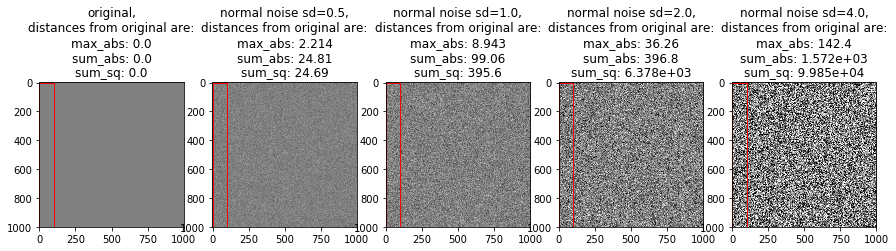

In [3]:
origin_shape = (1000, 1000)
origin = np.zeros(shape=origin_shape)
modifications = [(origin, "original")]
for i in range(1,5):
    mod = origin + np.random.normal(scale=2**i/4, size=origin_shape)
    modifications.append((mod, "normal noise sd={}".format(2**i/4)))
                         
draw_modifications_dist(modifications, vmin=-6, vmax=6, distances=['max_abs', 'sum_abs', 'sum_sq'])    

In [4]:
raw = np.load('raw_1.npy')
lift = np.load('lift_1.npy')
out = np.load('out_1.npy')
att = np.load('att_1.npy')

att = 1-att

In [5]:
def get_cv(arrs, q=0.95):
    return np.abs(np.quantile(np.stack(item for item in arrs), q))

cv = get_cv([raw])

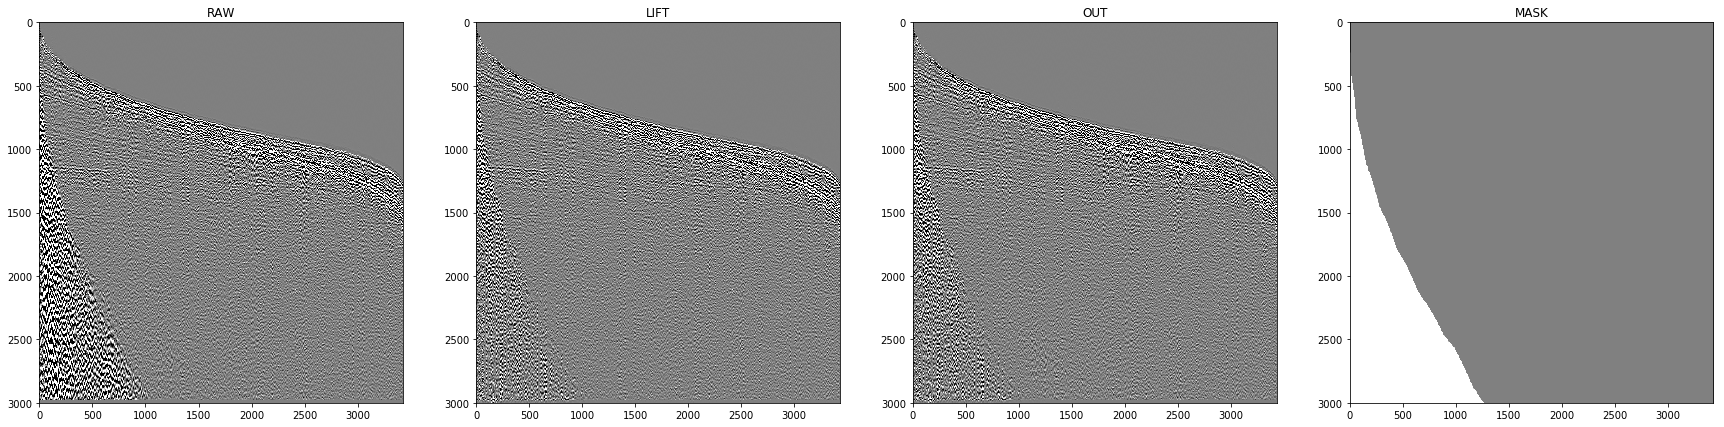

In [6]:
seismic_plot([raw, lift, out, att], figsize=(30, 7), names=['RAW', 'LIFT', 'OUT', 'MASK'],
             cmap='gray', vmin=-cv, vmax=cv)

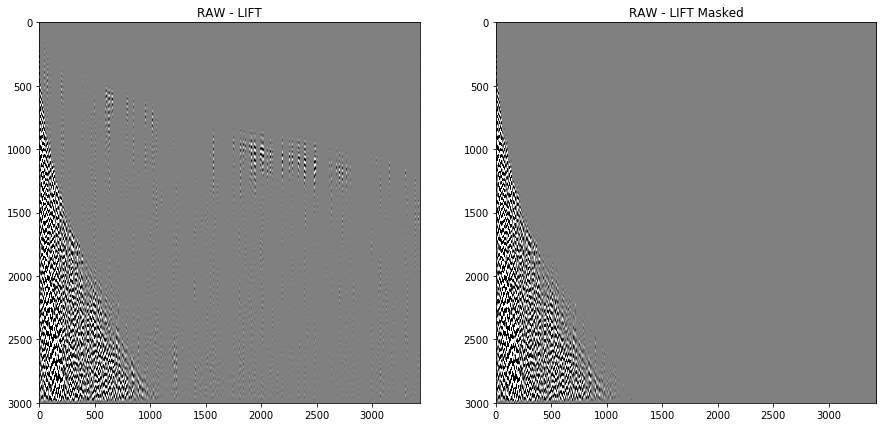

In [7]:
diff = raw - lift
diff_m = diff * att

seismic_plot([diff, diff_m], figsize=(15, 7), names=['RAW - LIFT', 'RAW - LIFT Masked'],
             cmap='gray', vmin=-cv, vmax=cv)

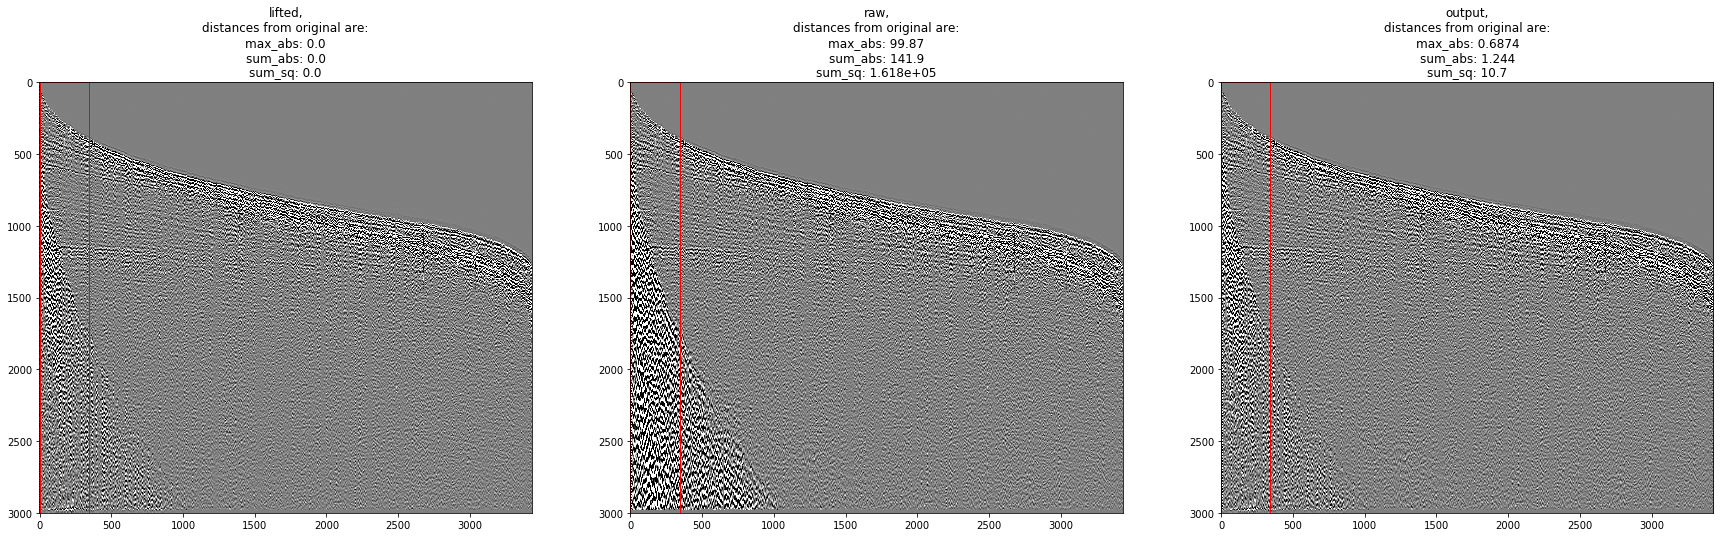

In [8]:
modifications = [(lift, "lifted"), (raw, "raw"), (out, "output")]

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 10))    

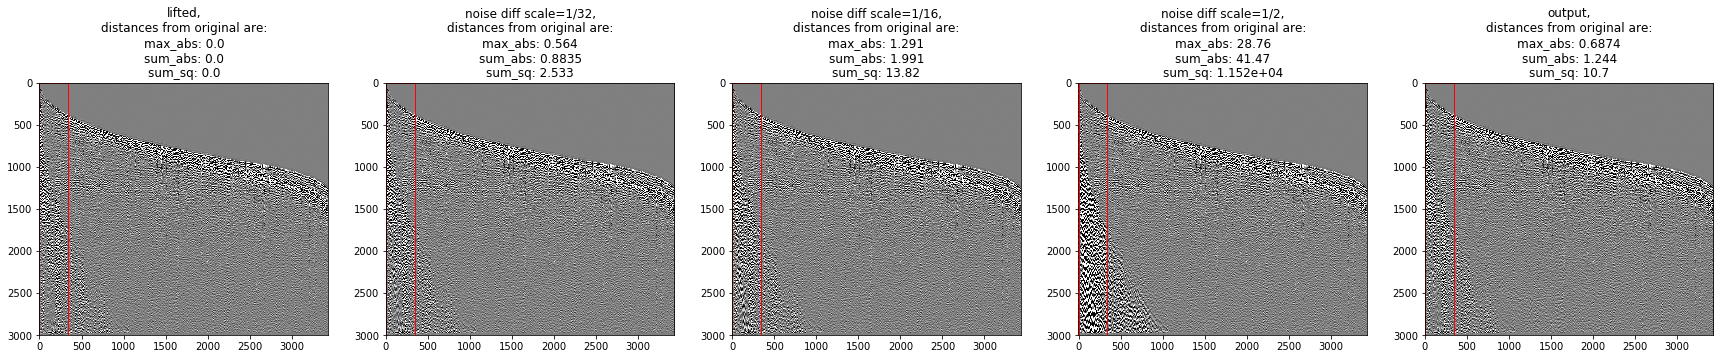

In [9]:
modifications = [(lift, "lifted")]

for scale in (32, 16, 2):
    mod = lift + diff_m / scale
    modifications.append((mod, "noise diff scale=1/{}".format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 10))    

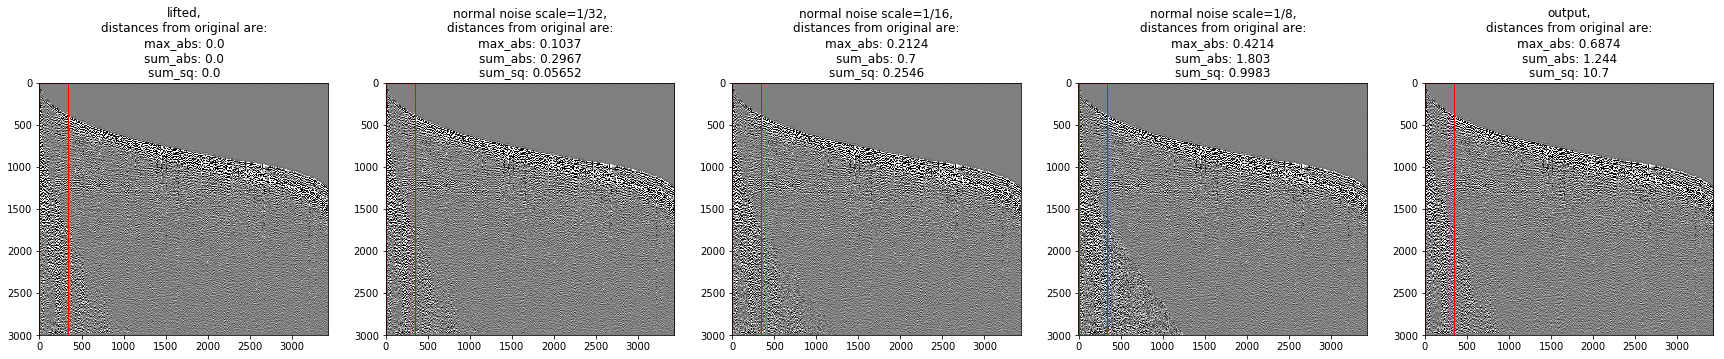

In [10]:
modifications = [(lift, "lifted")]

for scale in (32, 16, 8):
    mod = lift + np.random.normal(scale=1/scale, size=raw.shape) * att
    modifications.append((mod, "normal noise scale=1/{}".format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 15))    

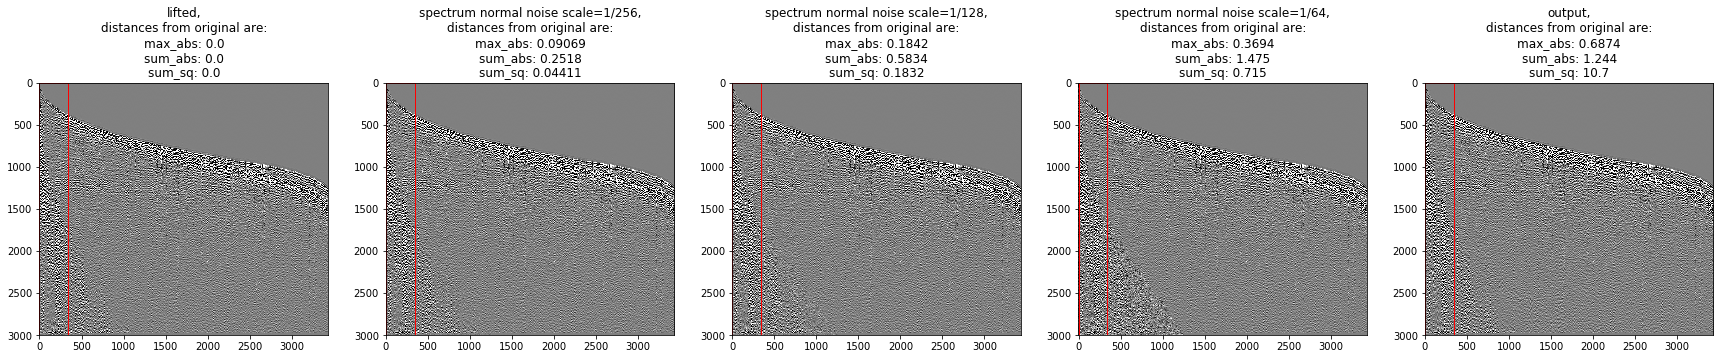

In [11]:
kwargs = dict(nperseg=100, noverlap=None, window=('tukey', 0.25))
f, t, Zxx = signal.stft(lift, **kwargs)

modifications = [(lift, "lifted")]
for scale in (256, 128, 64):  
    Zxx_n = Zxx + np.random.normal(scale=1/scale, size=Zxx.shape)
    _, lift_restored = signal.istft(Zxx_n, **kwargs)
    lift_restored = lift * (1 - att) + lift_restored * att
    modifications.append((lift_restored, 'spectrum normal noise scale=1/{}'.format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 15))    

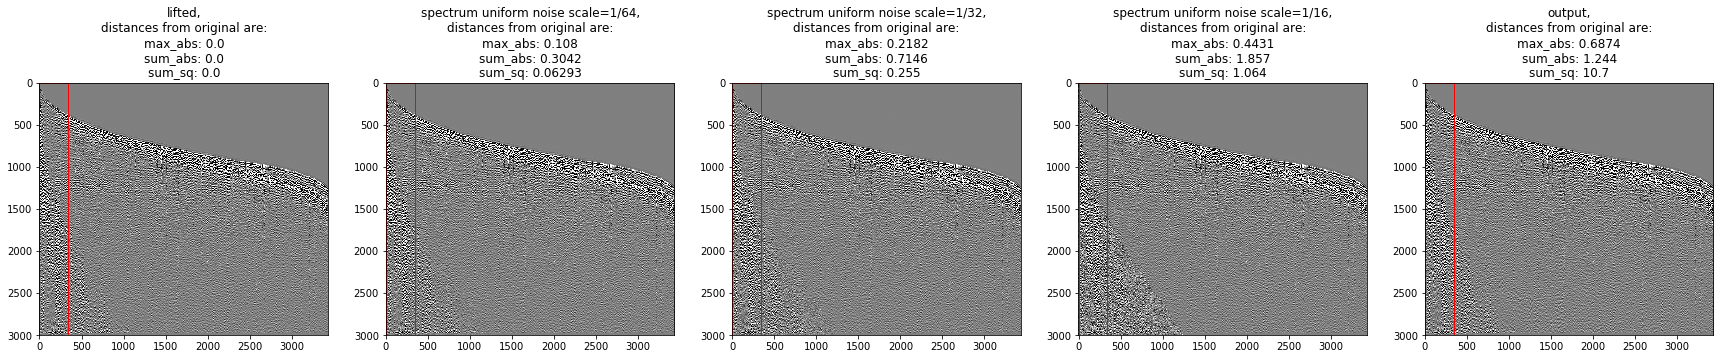

In [12]:
modifications = [(lift, "lifted")]
for scale in (64, 32, 16):  
    Zxx_n = Zxx + 1/scale * np.random.uniform(size=Zxx.shape)
    _, lift_restored = signal.istft(Zxx_n, **kwargs)
    lift_restored = lift * (1 - att) + lift_restored * att
    modifications.append((lift_restored, 'spectrum uniform noise scale=1/{}'.format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 15))        

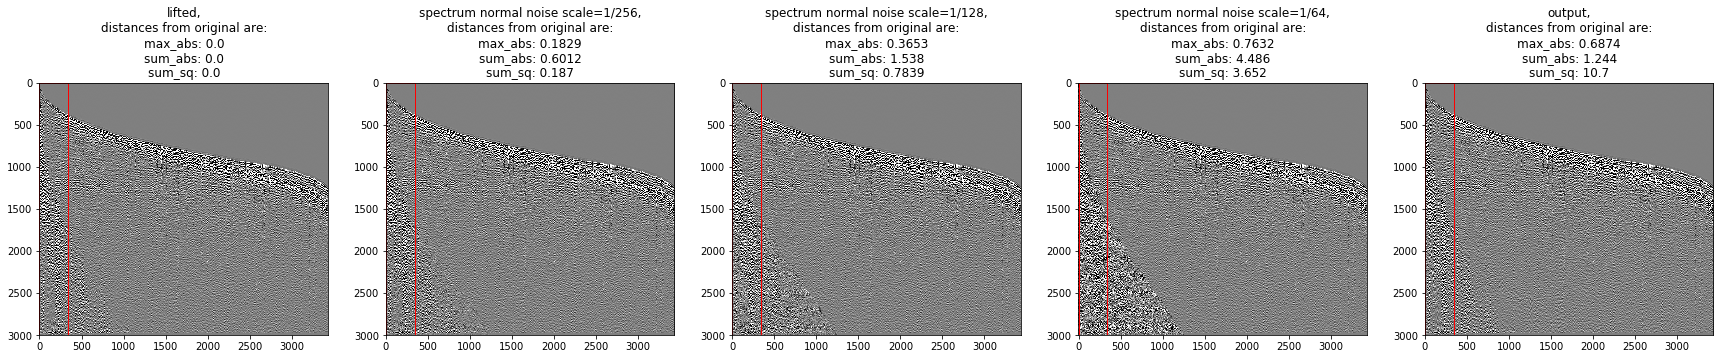

In [13]:
kwargs = dict(window='hann', nperseg=300, noverlap=100)
f, t, Zxx = signal.stft(lift, **kwargs)

modifications = [(lift, "lifted")]
for scale in (256, 128, 64):  
    Zxx_n = Zxx + np.random.normal(scale=1/scale, size=Zxx.shape)
    _, lift_restored = signal.istft(Zxx_n, **kwargs)
    lift_restored = lift * (1 - att) + lift_restored * att
    modifications.append((lift_restored, 'spectrum normal noise scale=1/{}'.format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 15))    

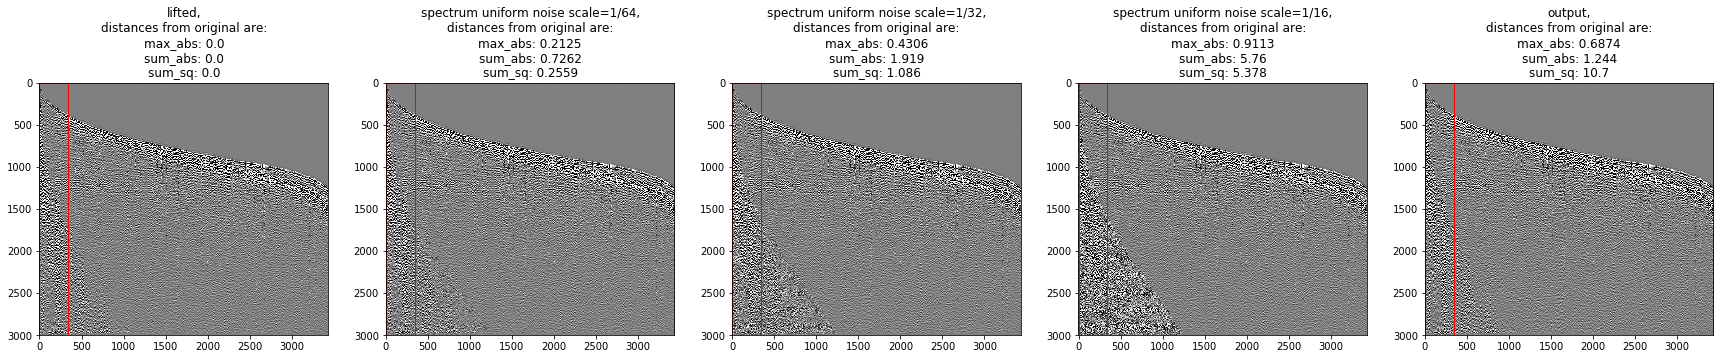

In [14]:
modifications = [(lift, "lifted")]
for scale in (64, 32, 16):  
    Zxx_n = Zxx + 1/scale * np.random.uniform(size=Zxx.shape)
    _, lift_restored = signal.istft(Zxx_n, **kwargs)
    lift_restored = lift * (1 - att) + lift_restored * att
    modifications.append((lift_restored, 'spectrum uniform noise scale=1/{}'.format(scale)))
    
modifications.append((out, "output"))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 15))        